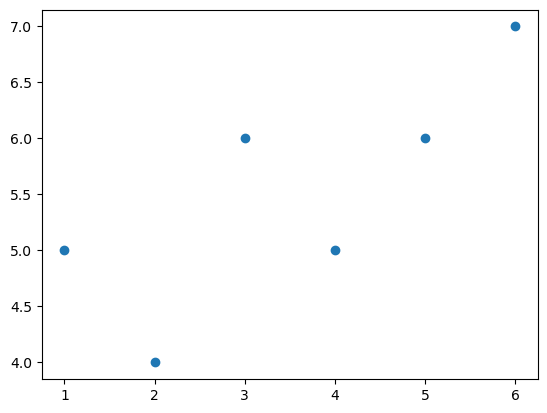

In [4]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt

xs = np.array([1, 2, 3, 4, 5, 6], dtype=np.float64)
ys = np.array([5, 4, 6, 5, 6, 7], dtype=np.float64)

plt.scatter(xs, ys)
plt.show()

In [7]:
def best_fit_slope(xs, ys):
    m = ( ( (mean(xs) * mean(ys)) - mean(xs*ys) ) /
            ((mean(xs)**2) - mean(xs**2)))
    
          
    return m

m = best_fit_slope(xs, ys)
print(m)


0.42857142857142866
